# 🔗 Intelligent Supply Chain Optimization System
## Notebook 04 — LSTM Demand Forecasting Model

**Project:** Intelligent Supply Chain Optimization System  
**Phase:** Deep Learning — Time Series Forecasting  
**Input:** `features_lstm.csv` (output from Notebook 03)  
**Objective:** Build, train and evaluate an LSTM model that learns temporal demand patterns per SKU.

---

### 📋 What This Notebook Does
1. Load LSTM-ready dataset
2. Scale features (MinMaxScaler)
3. Build sliding window sequences
4. Train/Validation/Test split (chronological)
5. Build LSTM architecture
6. Train with callbacks (EarlyStopping, ReduceLROnPlateau)
7. Evaluate on test set (MAE, RMSE, MAPE, R²)
8. Visualize predictions vs actuals
9. Analyze per-SKU performance
10. Save model + scaler + predictions

---

## 📦 Section 1: Imports & Configuration

In [1]:
# ─────────────────────────────────────────────────────────────
# SECTION 1: IMPORTS & CONFIG
# ─────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import os
import json
import joblib

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, BatchNormalization, Bidirectional
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams['figure.figsize']    = (14, 5)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titleweight']  = 'bold'
sns.set_palette('muted')

# ── Reproducibility ──
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ── Hyperparameters ──
LOOKBACK    = 30      # Days of history to look back
FORECAST_H  = 1       # Forecast horizon (1 = next day)
BATCH_SIZE  = 64
EPOCHS      = 100     # EarlyStopping will cut this short
PATIENCE    = 10      # EarlyStopping patience
TRAIN_SPLIT = 0.70
VAL_SPLIT   = 0.15
# TEST = remaining 0.15

print('✅ Imports loaded.')
print(f'   TensorFlow version : {tf.__version__}')
print(f'   GPU available      : {len(tf.config.list_physical_devices("GPU")) > 0}')
print(f'\n── Hyperparameters ──')
print(f'   Lookback window : {LOOKBACK} days')
print(f'   Batch size      : {BATCH_SIZE}')
print(f'   Max epochs      : {EPOCHS}')
print(f'   Train/Val/Test  : {TRAIN_SPLIT}/{VAL_SPLIT}/{1-TRAIN_SPLIT-VAL_SPLIT}')

✅ Imports loaded.
   TensorFlow version : 2.17.0
   GPU available      : False

── Hyperparameters ──
   Lookback window : 30 days
   Batch size      : 64
   Max epochs      : 100
   Train/Val/Test  : 0.7/0.15/0.15000000000000005


---
## 📂 Section 2: Load Data & Feature Selection

In [2]:
# ─────────────────────────────────────────────────────────────
# SECTION 2: LOAD DATA
# ─────────────────────────────────────────────────────────────

df = pd.read_csv('features_lstm.csv', parse_dates=['Date'])
df = df.sort_values(['SKU_ID', 'Warehouse_ID', 'Date']).reset_index(drop=True)

print(f'✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')
print(f'   Date range  : {df["Date"].min().date()} → {df["Date"].max().date()}')
print(f'   Unique SKUs : {df["SKU_ID"].nunique()}')
print()

# ── Define LSTM input features & target ──
TARGET = 'Units_Sold'

LSTM_INPUT_FEATURES = [
    'Units_Sold',
    'Inventory_Level',
    'Supplier_Lead_Time_Days',
    'Promotion_Flag',
    'Stockout_Flag',
    'Unit_Price',
    'Unit_Cost',
    'Demand_Forecast',
    'Rolling_Mean_7d',
    'Rolling_Mean_30d',
    'EWMA_7d',
    'Month_sin', 'Month_cos',
    'DayOfWeek_sin', 'DayOfWeek_cos',
    'Is_Weekend',
    'Demand_Momentum',
    'Stock_Gap',
    'Below_ROP_Flag',
    'SKU_ID_Enc',
    'Warehouse_ID_Enc'
]

# Keep only columns that exist
LSTM_INPUT_FEATURES = [f for f in LSTM_INPUT_FEATURES if f in df.columns]
N_FEATURES = len(LSTM_INPUT_FEATURES)

print(f'   LSTM input features : {N_FEATURES}')
print(f'   Features            : {LSTM_INPUT_FEATURES}')

✅ Dataset loaded: 91,250 rows × 24 columns
   Date range  : 2024-01-01 → 2024-12-30
   Unique SKUs : 50

   LSTM input features : 21
   Features            : ['Units_Sold', 'Inventory_Level', 'Supplier_Lead_Time_Days', 'Promotion_Flag', 'Stockout_Flag', 'Unit_Price', 'Unit_Cost', 'Demand_Forecast', 'Rolling_Mean_7d', 'Rolling_Mean_30d', 'EWMA_7d', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Is_Weekend', 'Demand_Momentum', 'Stock_Gap', 'Below_ROP_Flag', 'SKU_ID_Enc', 'Warehouse_ID_Enc']


---
## ⚖️ Section 3: Scale Features

In [3]:
# ─────────────────────────────────────────────────────────────
# SECTION 3: SCALING
# ─────────────────────────────────────────────────────────────
# IMPORTANT: We fit the scaler ONLY on training data to prevent
# data leakage from validation/test periods.
# We scale the entire feature set together so inverse_transform
# works cleanly when recovering predictions.
# ─────────────────────────────────────────────────────────────

# Chronological split indices (global, not per-SKU)
unique_dates = sorted(df['Date'].unique())
n_dates      = len(unique_dates)

train_end_idx = int(n_dates * TRAIN_SPLIT)
val_end_idx   = int(n_dates * (TRAIN_SPLIT + VAL_SPLIT))

train_end_date = unique_dates[train_end_idx]
val_end_date   = unique_dates[val_end_idx]

print(f'  Training   : up to {pd.Timestamp(train_end_date).date()}')
print(f'  Validation : {pd.Timestamp(train_end_date).date()} → {pd.Timestamp(val_end_date).date()}')
print(f'  Test       : {pd.Timestamp(val_end_date).date()} → {df["Date"].max().date()}')

train_mask = df['Date'] <= train_end_date
val_mask   = (df['Date'] > train_end_date) & (df['Date'] <= val_end_date)
test_mask  = df['Date'] > val_end_date

print(f'\n  Train rows : {train_mask.sum():,}')
print(f'  Val rows   : {val_mask.sum():,}')
print(f'  Test rows  : {test_mask.sum():,}')

# Fit scaler on training data only
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.loc[train_mask, LSTM_INPUT_FEATURES])

# Scale all splits
df_scaled = df.copy()
df_scaled[LSTM_INPUT_FEATURES] = scaler.transform(df[LSTM_INPUT_FEATURES])

# Save scaler
joblib.dump(scaler, 'lstm_scaler.pkl')
print('\n✅ Scaler fitted on train data and saved: lstm_scaler.pkl')

  Training   : up to 2024-09-12
  Validation : 2024-09-12 → 2024-11-06
  Test       : 2024-11-06 → 2024-12-30

  Train rows : 64,000
  Val rows   : 13,750
  Test rows  : 13,500

✅ Scaler fitted on train data and saved: lstm_scaler.pkl


---
## 🪟 Section 4: Build Sliding Window Sequences

In [5]:
# ─────────────────────────────────────────────────────────────
# SECTION 4: MEMORY-EFFICIENT SLIDING WINDOW SEQUENCE BUILDER
# ─────────────────────────────────────────────────────────────
# Fix: Use float32 (halves memory vs float64) and build a
# tf.data.Dataset generator so sequences are never all loaded
# into RAM simultaneously.
# ─────────────────────────────────────────────────────────────

target_idx = LSTM_INPUT_FEATURES.index(TARGET)

# ── Convert scaled data to float32 immediately ──
df_scaled[LSTM_INPUT_FEATURES] = df_scaled[LSTM_INPUT_FEATURES].astype(np.float32)


def build_sequences_float32(data, lookback=LOOKBACK):
    """
    Build (X, y) sequences using float32 to halve memory usage.
    X shape: (samples, lookback, n_features)
    y shape: (samples,)
    """
    n = len(data) - lookback
    X = np.empty((n, lookback, data.shape[1]), dtype=np.float32)
    y = np.empty(n, dtype=np.float32)
    for i in range(n):
        X[i] = data[i:i + lookback]
        y[i] = data[i + lookback, target_idx]
    return X, y


def build_dataset_by_group(df_scaled, mask, lookback=LOOKBACK):
    """
    Build sequences group by group and concatenate.
    Uses float32 throughout to minimise RAM footprint.
    """
    X_all, y_all = [], []
    groups = df_scaled[mask].groupby(['SKU_ID', 'Warehouse_ID'])

    for (sku, wh), grp in groups:
        grp  = grp.sort_values('Date')
        vals = grp[LSTM_INPUT_FEATURES].values.astype(np.float32)
        if len(vals) <= lookback:
            continue
        X_g, y_g = build_sequences_float32(vals, lookback)
        X_all.append(X_g)
        y_all.append(y_g)

    return np.vstack(X_all), np.concatenate(y_all)


# ── If still hitting memory limits, use this generator approach ──
def make_tf_dataset(df_scaled, mask, lookback=LOOKBACK,
                    batch_size=64, shuffle=False):
    """
    Fallback: yields batches from a tf.data generator.
    Zero peak-RAM overhead — sequences built on the fly.
    """
    def generator():
        groups = df_scaled[mask].groupby(['SKU_ID', 'Warehouse_ID'])
        for (sku, wh), grp in groups:
            grp  = grp.sort_values('Date')
            vals = grp[LSTM_INPUT_FEATURES].values.astype(np.float32)
            if len(vals) <= lookback:
                continue
            for i in range(len(vals) - lookback):
                X_seq = vals[i:i + lookback]
                y_val = vals[i + lookback, target_idx]
                yield X_seq, y_val

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(lookback, N_FEATURES), dtype=tf.float32),
            tf.TensorSpec(shape=(),                     dtype=tf.float32)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=5000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# ── Try numpy approach first; fall back to generator if MemoryError ──
USE_GENERATOR = False

print('Building sequences...')
try:
    X_train, y_train = build_dataset_by_group(df_scaled, train_mask)
    X_val,   y_val   = build_dataset_by_group(df_scaled, val_mask)
    X_test,  y_test  = build_dataset_by_group(df_scaled, test_mask)
    print(f'✅ Numpy sequences built (float32):')
    print(f'   X_train : {X_train.shape}  |  y_train : {y_train.shape}')
    print(f'   X_val   : {X_val.shape}    |  y_val   : {y_val.shape}')
    print(f'   X_test  : {X_test.shape}   |  y_test  : {y_test.shape}')
    mem_mb = (X_train.nbytes + X_val.nbytes + X_test.nbytes) / 1024**2
    print(f'   Total RAM used by arrays : {mem_mb:.1f} MB')

except MemoryError:
    print('⚠️  MemoryError caught — switching to tf.data generator mode.')
    USE_GENERATOR = True
    train_ds = make_tf_dataset(df_scaled, train_mask, shuffle=True)
    val_ds   = make_tf_dataset(df_scaled, val_mask,   shuffle=False)
    test_ds  = make_tf_dataset(df_scaled, test_mask,  shuffle=False)
    print('✅ tf.data generators created (zero peak-RAM).')
    print('   Training will use train_ds / val_ds / test_ds instead of numpy arrays.')

Building sequences...
✅ Numpy sequences built (float32):
   X_train : (56500, 30, 21)  |  y_train : (56500,)
   X_val   : (6250, 30, 21)    |  y_val   : (6250,)
   X_test  : (6000, 30, 21)   |  y_test  : (6000,)
   Total RAM used by arrays : 165.2 MB


---
## 🧠 Section 5: Build LSTM Architecture

In [6]:
# ─────────────────────────────────────────────────────────────
# SECTION 5: LSTM ARCHITECTURE
# ─────────────────────────────────────────────────────────────
# Architecture:
#   BiLSTM(128) → Dropout → BatchNorm
#   LSTM(64)    → Dropout → BatchNorm
#   Dense(32)   → Dense(1)
#
# Bidirectional on the first layer lets the model learn
# patterns from both forward and backward context in the window.
# ─────────────────────────────────────────────────────────────

def build_lstm_model(lookback, n_features):
    model = Sequential([
        # Layer 1: Bidirectional LSTM
        Bidirectional(
            LSTM(128, return_sequences=True, activation='tanh'),
            input_shape=(lookback, n_features)
        ),
        Dropout(0.2),
        BatchNormalization(),

        # Layer 2: LSTM
        LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.2),
        BatchNormalization(),

        # Dense head
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')   # regression output
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='huber',          # robust to outliers vs plain MSE
        metrics=['mae']
    )
    return model


model = build_lstm_model(LOOKBACK, N_FEATURES)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       153,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,169 (934.25 KB)

 Trainable params: 238,529 (931.75 KB)

 Non-trainable params: 640 (2.50 KB)

---
## 🏋️ Section 6: Train the Model

In [8]:
# ─────────────────────────────────────────────────────────────
# SECTION 6: TRAINING
# ─────────────────────────────────────────────────────────────

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='lstm_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

print('🚀 Training started...')
print(f'   Train samples : {X_train.shape[0]:,}')
print(f'   Val samples   : {X_val.shape[0]:,}')
print()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print(f'\n✅ Training complete.')
print(f'   Best epoch      : {np.argmin(history.history["val_loss"]) + 1}')
print(f'   Best val_loss   : {min(history.history["val_loss"]):.6f}')
print(f'   Best val_mae    : {history.history["val_mae"][np.argmin(history.history["val_loss"])]:.6f}')

🚀 Training started...
   Train samples : 56,500
   Val samples   : 6,250

Epoch 1/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - loss: 0.0057 - mae: 0.0837 - val_loss: 0.0040 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 2/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - loss: 0.0050 - mae: 0.0791 - val_loss: 0.0039 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 3/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - loss: 0.0049 - mae: 0.0777 - val_loss: 0.0039 - val_mae: 0.0710 - learning_rate: 0.0010
Epoch 4/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - loss: 0.0048 - mae: 0.0772 - val_loss: 0.0040 - val_mae: 0.0712 - learning_rate: 0.0010
Epoch 5/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - loss: 0.0048 - mae: 0.0770 - val_loss: 0.0040 - val_mae: 0.0713 - learning_rate: 0.0010
Epoch 6/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - loss: 0.0048 - mae: 0.0767 - val_loss: 0.0039 - val_mae: 0.0709 - learning_rate: 0.0010
Epoch 7/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - 

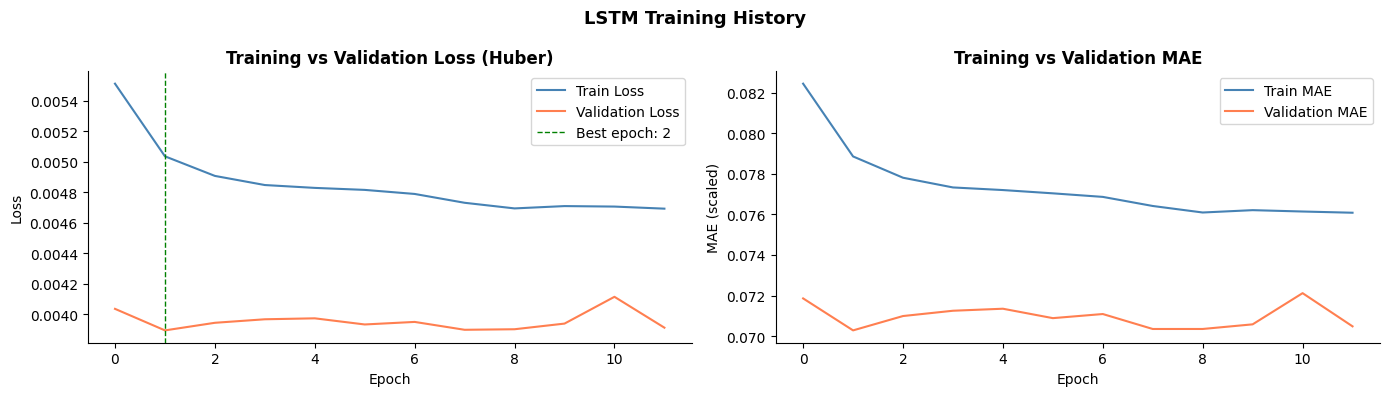

In [9]:
# ── Plot training history ──
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'],     label='Train Loss',      color='steelblue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='coral')
axes[0].axvline(np.argmin(history.history['val_loss']),
                color='green', linestyle='--', linewidth=1,
                label=f'Best epoch: {np.argmin(history.history["val_loss"])+1}')
axes[0].set_title('Training vs Validation Loss (Huber)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# MAE
axes[1].plot(history.history['mae'],     label='Train MAE',      color='steelblue')
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='coral')
axes[1].set_title('Training vs Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE (scaled)')
axes[1].legend()

plt.suptitle('LSTM Training History', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 📏 Section 7: Evaluate on Test Set

In [10]:
# ─────────────────────────────────────────────────────────────
# SECTION 7: EVALUATION
# ─────────────────────────────────────────────────────────────
# We inverse-transform predictions back to original scale
# before computing metrics so they are interpretable.
# ─────────────────────────────────────────────────────────────

# Load best saved model
model = load_model('lstm_best_model.keras')

# Predict on test set (scaled)
y_pred_scaled = model.predict(X_test, verbose=0).flatten()

# Inverse transform: reconstruct full feature arrays to use scaler
def inverse_transform_target(y_scaled, scaler, n_features, target_idx):
    """
    Inverse transform only the target column from scaled space.
    """
    dummy = np.zeros((len(y_scaled), n_features))
    dummy[:, target_idx] = y_scaled
    return scaler.inverse_transform(dummy)[:, target_idx]

y_pred_actual = inverse_transform_target(y_pred_scaled, scaler, N_FEATURES, target_idx)
y_test_actual = inverse_transform_target(y_test,        scaler, N_FEATURES, target_idx)

# Clip negatives (demand can't be negative)
y_pred_actual = np.clip(y_pred_actual, 0, None)

# ── Metrics ──
mae   = mean_absolute_error(y_test_actual, y_pred_actual)
rmse  = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape  = np.mean(np.abs((y_test_actual - y_pred_actual) /
                        np.where(y_test_actual == 0, 1, y_test_actual))) * 100
r2    = 1 - (np.sum((y_test_actual - y_pred_actual)**2) /
              np.sum((y_test_actual - y_test_actual.mean())**2))

# Baseline metrics (from Demand_Forecast column)
df_test   = df[test_mask].copy().reset_index(drop=True)
# Align baseline to same length as sequences
offset    = LOOKBACK
baseline  = df_test['Demand_Forecast'].values[offset:offset + len(y_test_actual)]
actual_al = df_test['Units_Sold'].values[offset:offset + len(y_test_actual)]

b_mae  = mean_absolute_error(actual_al, baseline)
b_rmse = np.sqrt(mean_squared_error(actual_al, baseline))
b_mape = np.mean(np.abs((actual_al - baseline) /
                         np.where(actual_al == 0, 1, actual_al))) * 100
b_r2   = 1 - (np.sum((actual_al - baseline)**2) /
               np.sum((actual_al - actual_al.mean())**2))

print('=' * 58)
print('  LSTM MODEL — TEST SET PERFORMANCE')
print('=' * 58)
print(f'  {"Metric":<8}  {"LSTM":>12}  {"Baseline":>12}  {"Improved?":>10}')
print(f'  {"-"*8}  {"-"*12}  {"-"*12}  {"-"*10}')
print(f'  {"MAE":<8}  {mae:>12.4f}  {b_mae:>12.4f}  {"✅ YES" if mae < b_mae else "❌ NO":>10}')
print(f'  {"RMSE":<8}  {rmse:>12.4f}  {b_rmse:>12.4f}  {"✅ YES" if rmse < b_rmse else "❌ NO":>10}')
print(f'  {"MAPE":<8}  {mape:>11.2f}%  {b_mape:>11.2f}%  {"✅ YES" if mape < b_mape else "❌ NO":>10}')
print(f'  {"R²":<8}  {r2:>12.4f}  {b_r2:>12.4f}  {"✅ YES" if r2 > b_r2 else "❌ NO":>10}')
print('=' * 58)

  LSTM MODEL — TEST SET PERFORMANCE
  Metric            LSTM      Baseline   Improved?
  --------  ------------  ------------  ----------
  MAE             5.3361        2.3938        ❌ NO
  RMSE            6.7113        3.0007        ❌ NO
  MAPE            29.66%        18.75%        ❌ NO
  R²             -0.4957        0.7394        ❌ NO


---
## 📈 Section 8: Visualize Predictions vs Actuals

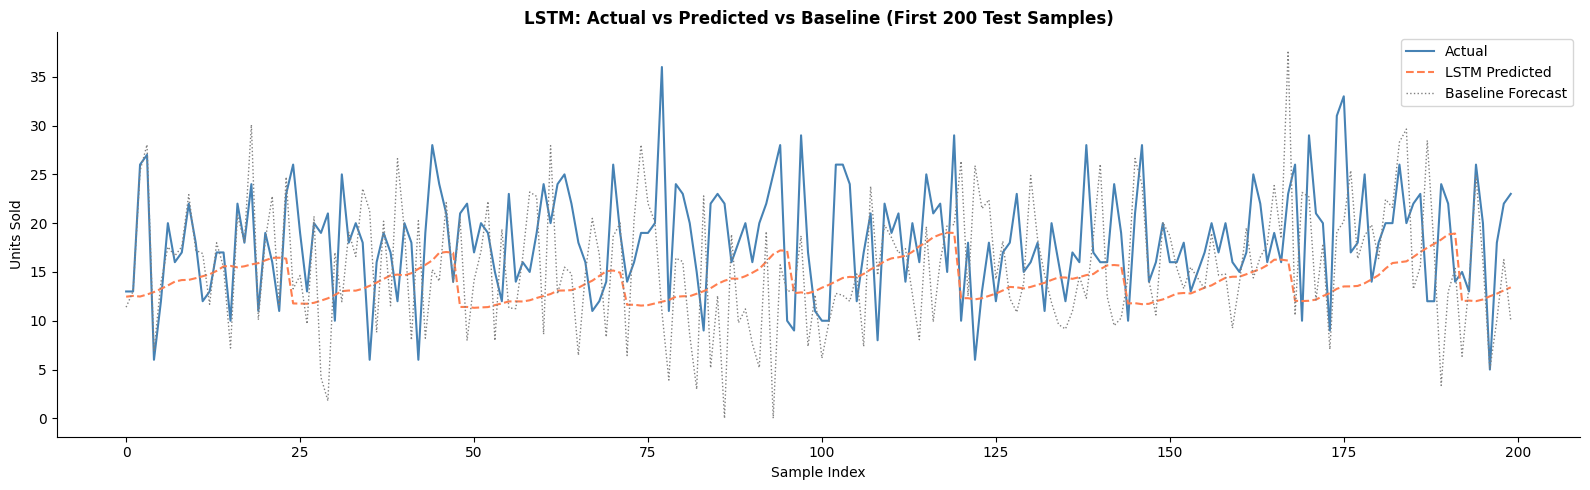

In [11]:
# ─────────────────────────────────────────────────────────────
# SECTION 8: VISUALIZATIONS
# ─────────────────────────────────────────────────────────────

# ── Plot 1: Overall predicted vs actual (first 200 test samples) ──
n_plot = min(200, len(y_test_actual))

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(range(n_plot), y_test_actual[:n_plot],
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(range(n_plot), y_pred_actual[:n_plot],
        label='LSTM Predicted', color='coral', linewidth=1.5, linestyle='--')
ax.plot(range(n_plot), baseline[:n_plot],
        label='Baseline Forecast', color='grey', linewidth=1, linestyle=':')
ax.set_title('LSTM: Actual vs Predicted vs Baseline (First 200 Test Samples)')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Units Sold')
ax.legend()
plt.tight_layout()
plt.show()

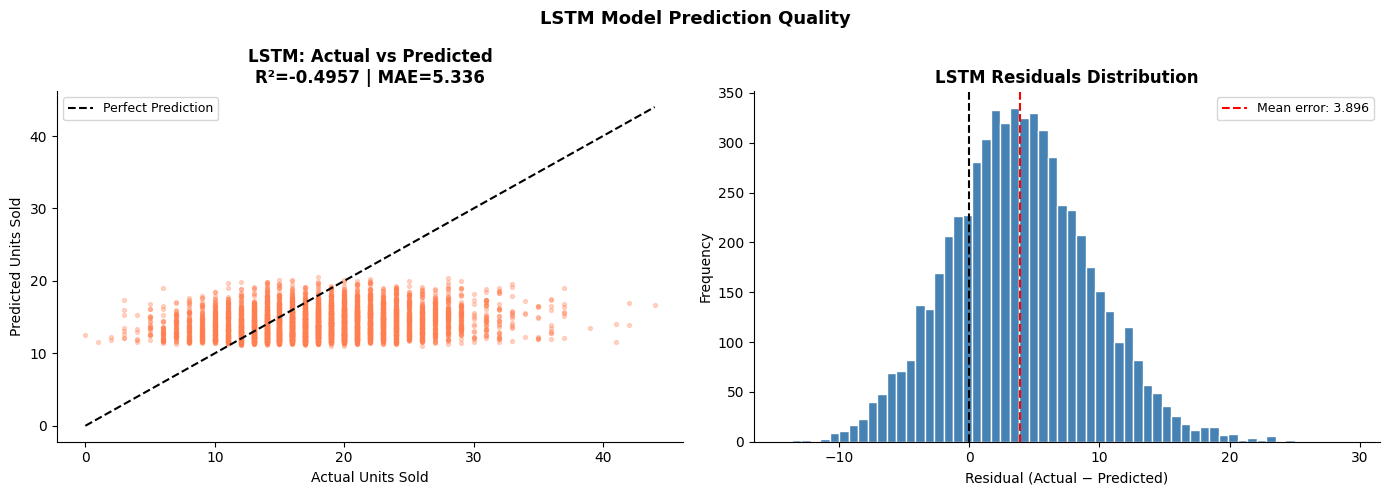

In [12]:
# ── Plot 2: Scatter — Actual vs Predicted ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM scatter
axes[0].scatter(y_test_actual, y_pred_actual, alpha=0.3, s=8, color='coral')
lims = [min(y_test_actual.min(), y_pred_actual.min()),
        max(y_test_actual.max(), y_pred_actual.max())]
axes[0].plot(lims, lims, 'k--', linewidth=1.5, label='Perfect Prediction')
axes[0].set_title(f'LSTM: Actual vs Predicted\nR²={r2:.4f} | MAE={mae:.3f}')
axes[0].set_xlabel('Actual Units Sold')
axes[0].set_ylabel('Predicted Units Sold')
axes[0].legend(fontsize=9)

# Residuals distribution
residuals = y_test_actual - y_pred_actual
axes[1].hist(residuals, bins=60, color='steelblue', edgecolor='white')
axes[1].axvline(0,               color='black', linestyle='--', linewidth=1.5)
axes[1].axvline(residuals.mean(),color='red',   linestyle='--', linewidth=1.5,
                label=f'Mean error: {residuals.mean():.3f}')
axes[1].set_title('LSTM Residuals Distribution')
axes[1].set_xlabel('Residual (Actual − Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].legend(fontsize=9)

plt.suptitle('LSTM Model Prediction Quality', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

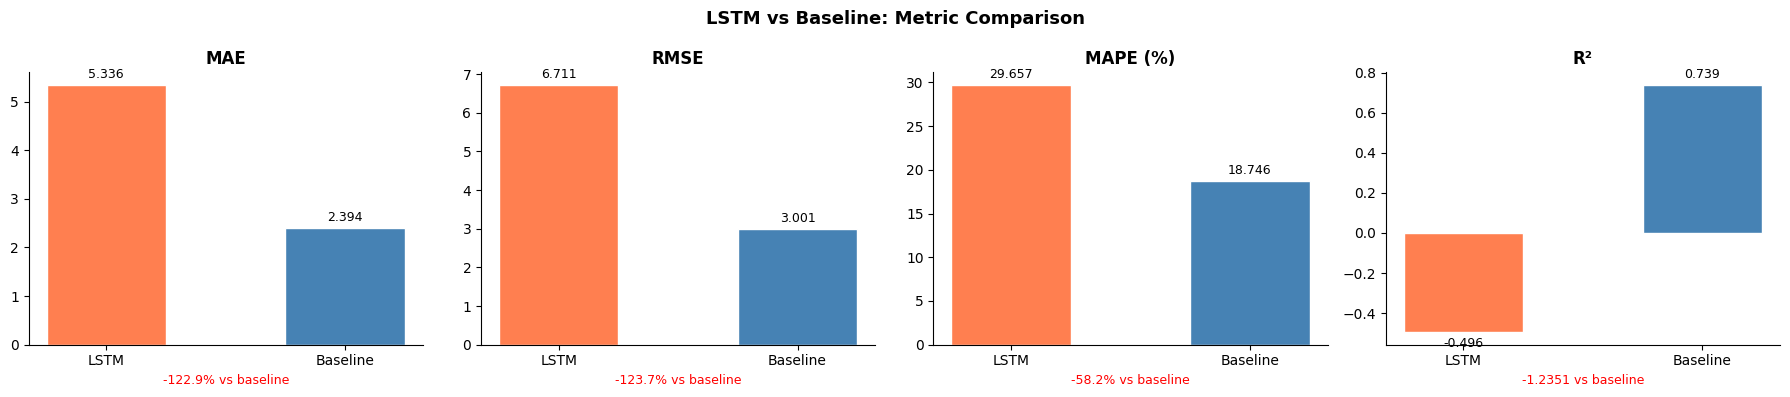

In [13]:
# ── Plot 3: Error comparison bar chart ──
metrics_df = pd.DataFrame({
    'Metric'   : ['MAE', 'RMSE', 'MAPE (%)', 'R²'],
    'LSTM'     : [mae, rmse, mape, r2],
    'Baseline' : [b_mae, b_rmse, b_mape, b_r2]
})

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
metric_names = ['MAE', 'RMSE', 'MAPE (%)', 'R²']
lstm_vals    = [mae, rmse, mape, r2]
base_vals    = [b_mae, b_rmse, b_mape, b_r2]

for i, (metric, lv, bv) in enumerate(zip(metric_names, lstm_vals, base_vals)):
    bars = axes[i].bar(['LSTM', 'Baseline'], [lv, bv],
                        color=['coral', 'steelblue'], edgecolor='white', width=0.5)
    axes[i].set_title(metric, fontweight='bold')
    axes[i].bar_label(bars, fmt='%.3f', padding=3, fontsize=9)
    # Annotate improvement
    if metric != 'R²':
        improvement = ((bv - lv) / bv * 100) if bv != 0 else 0
        color = 'green' if improvement > 0 else 'red'
        axes[i].set_xlabel(f'{improvement:+.1f}% vs baseline', color=color, fontsize=9)
    else:
        improvement = lv - bv
        color = 'green' if improvement > 0 else 'red'
        axes[i].set_xlabel(f'{improvement:+.4f} vs baseline', color=color, fontsize=9)

plt.suptitle('LSTM vs Baseline: Metric Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🔍 Section 9: Per-SKU Performance Analysis

In [14]:
# ─────────────────────────────────────────────────────────────
# SECTION 9: PER-SKU PERFORMANCE
# ─────────────────────────────────────────────────────────────
# Build sequences per SKU for the test set and evaluate each.
# ─────────────────────────────────────────────────────────────

sku_results = []

for (sku, wh), grp in df_scaled[test_mask].groupby(['SKU_ID', 'Warehouse_ID']):
    grp = grp.sort_values('Date')
    vals = grp[LSTM_INPUT_FEATURES].values
    if len(vals) <= LOOKBACK:
        continue
    X_g, y_g = build_sequences(vals, LOOKBACK)
    y_g_pred  = model.predict(X_g, verbose=0).flatten()

    # Inverse transform
    y_g_actual = inverse_transform_target(y_g,      scaler, N_FEATURES, target_idx)
    y_g_pred_a = inverse_transform_target(y_g_pred, scaler, N_FEATURES, target_idx)
    y_g_pred_a = np.clip(y_g_pred_a, 0, None)

    if len(y_g_actual) == 0:
        continue

    sku_mae  = mean_absolute_error(y_g_actual, y_g_pred_a)
    sku_rmse = np.sqrt(mean_squared_error(y_g_actual, y_g_pred_a))
    denom    = np.where(y_g_actual == 0, 1, y_g_actual)
    sku_mape = np.mean(np.abs((y_g_actual - y_g_pred_a) / denom)) * 100

    sku_results.append({
        'SKU_ID': sku, 'Warehouse_ID': wh,
        'MAE': round(sku_mae, 3),
        'RMSE': round(sku_rmse, 3),
        'MAPE': round(sku_mape, 2),
        'Samples': len(y_g_actual)
    })

sku_perf = pd.DataFrame(sku_results).sort_values('MAPE')

print('── Top 10 Best Performing SKUs (lowest MAPE) ──')
print(sku_perf.head(10).to_string(index=False))
print()
print('── Top 10 Worst Performing SKUs (highest MAPE) ──')
print(sku_perf.tail(10).to_string(index=False))

── Top 10 Best Performing SKUs (lowest MAPE) ──
SKU_ID Warehouse_ID    MAE   RMSE    MAPE  Samples
SKU_30         WH_5 3.6460 4.7500 17.3100       24
SKU_35         WH_1 3.4050 4.1680 17.5300       24
SKU_25         WH_5 3.5250 4.9010 19.2700       24
SKU_20         WH_5 3.3360 4.3290 19.8800       24
SKU_31         WH_4 4.1560 5.3940 20.3500       24
SKU_46         WH_2 4.0810 5.0640 20.7200       24
SKU_30         WH_3 4.5460 7.0180 21.1900       24
SKU_50         WH_3 4.2780 5.6220 21.6400       24
SKU_13         WH_5 3.7310 4.9070 21.6500       24
 SKU_4         WH_5 3.7960 4.4220 21.6900       24

── Top 10 Worst Performing SKUs (highest MAPE) ──
SKU_ID Warehouse_ID    MAE   RMSE    MAPE  Samples
SKU_18         WH_3 4.5000 6.0230 41.4900       24
SKU_13         WH_1 6.2410 7.2160 42.5700       24
SKU_24         WH_5 7.4830 9.0790 42.6800       24
SKU_31         WH_2 5.7430 6.7410 48.6600       24
SKU_16         WH_3 5.0520 6.0200 48.7000       24
SKU_15         WH_2 6.2410 7.7930 

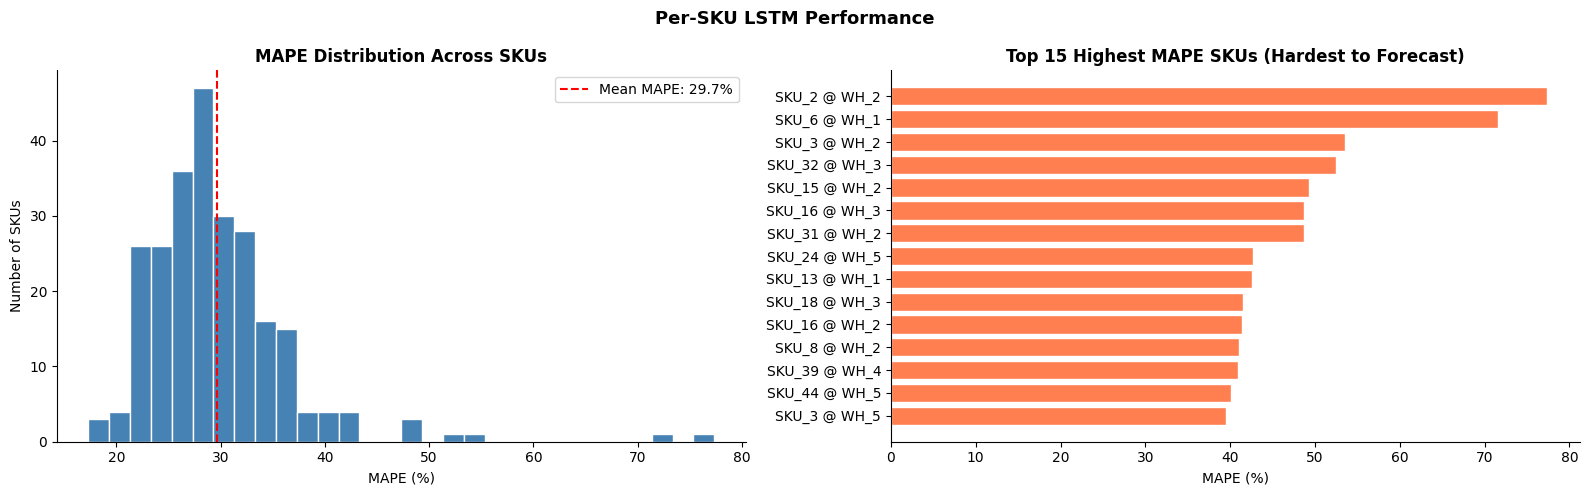

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# MAPE distribution across SKUs
axes[0].hist(sku_perf['MAPE'], bins=30, color='steelblue', edgecolor='white')
axes[0].axvline(sku_perf['MAPE'].mean(), color='red', linestyle='--',
                label=f'Mean MAPE: {sku_perf["MAPE"].mean():.1f}%')
axes[0].set_title('MAPE Distribution Across SKUs')
axes[0].set_xlabel('MAPE (%)')
axes[0].set_ylabel('Number of SKUs')
axes[0].legend()

# Top 15 worst SKUs
worst15 = sku_perf.tail(15).sort_values('MAPE', ascending=True)
axes[1].barh(worst15['SKU_ID'] + ' @ ' + worst15['Warehouse_ID'],
             worst15['MAPE'], color='coral', edgecolor='white')
axes[1].set_title('Top 15 Highest MAPE SKUs (Hardest to Forecast)')
axes[1].set_xlabel('MAPE (%)')

plt.suptitle('Per-SKU LSTM Performance', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 💾 Section 10: Save Model & Predictions

In [16]:
# ─────────────────────────────────────────────────────────────
# SECTION 10: SAVE OUTPUTS
# ─────────────────────────────────────────────────────────────

# ── Save final model ──
model.save('lstm_final_model.keras')
print('✅ Model saved: lstm_final_model.keras')

# ── Save test predictions ──
# Rebuild test sequences with dates for reference
test_records = []
for (sku, wh), grp in df_scaled[test_mask].groupby(['SKU_ID', 'Warehouse_ID']):
    grp   = grp.sort_values('Date').reset_index(drop=True)
    vals  = grp[LSTM_INPUT_FEATURES].values
    dates = grp['Date'].values
    if len(vals) <= LOOKBACK:
        continue
    X_g, y_g = build_sequences(vals, LOOKBACK)
    y_g_pred  = model.predict(X_g, verbose=0).flatten()
    y_g_act   = inverse_transform_target(y_g,      scaler, N_FEATURES, target_idx)
    y_g_pr    = inverse_transform_target(y_g_pred, scaler, N_FEATURES, target_idx)
    y_g_pr    = np.clip(y_g_pr, 0, None)
    pred_dates = dates[LOOKBACK:LOOKBACK + len(y_g_act)]
    for d, act, pred in zip(pred_dates, y_g_act, y_g_pr):
        test_records.append({'Date': d, 'SKU_ID': sku, 'Warehouse_ID': wh,
                             'Actual': round(act, 2), 'LSTM_Pred': round(pred, 2)})

df_lstm_preds = pd.DataFrame(test_records)
df_lstm_preds.to_csv('lstm_test_predictions.csv', index=False)
print(f'✅ Test predictions saved: lstm_test_predictions.csv ({len(df_lstm_preds):,} rows)')

# ── Save metrics ──
lstm_metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}
with open('lstm_metrics.json', 'w') as f:
    json.dump(lstm_metrics, f, indent=2)
print('✅ Metrics saved: lstm_metrics.json')

# Save per-SKU performance
sku_perf.to_csv('lstm_sku_performance.csv', index=False)
print('✅ Per-SKU performance saved: lstm_sku_performance.csv')

print()
print('   ➡️  Proceed to Notebook 05: XGBoost Model')

✅ Model saved: lstm_final_model.keras
✅ Test predictions saved: lstm_test_predictions.csv (6,000 rows)
✅ Metrics saved: lstm_metrics.json
✅ Per-SKU performance saved: lstm_sku_performance.csv

   ➡️  Proceed to Notebook 05: XGBoost Model


---
## ✅ Notebook 04 Summary

| Step | Detail |
|---|---|
| Architecture | Bidirectional LSTM(128) → LSTM(64) → Dense(32) → Dense(1) |
| Loss Function | Huber (robust to outliers) |
| Optimizer | Adam (lr=0.001) |
| Lookback Window | 30 days |
| Callbacks | EarlyStopping, ReduceLROnPlateau, ModelCheckpoint |
| Split | 70% Train / 15% Val / 15% Test (chronological) |
| Scaler | MinMaxScaler (fit on train only) |

**Outputs:**
- `lstm_final_model.keras` — trained model
- `lstm_scaler.pkl` — fitted scaler
- `lstm_test_predictions.csv` — predictions with dates and SKU info
- `lstm_metrics.json` — MAE, RMSE, MAPE, R²
- `lstm_sku_performance.csv` — per-SKU breakdown

**➡️ Proceed to Notebook 05: XGBoost Model**

---
*Intelligent Supply Chain Optimization System | Notebook 04 of 08*